# TF-IDF and k-Means Clustering in Amazon Reviews

In [124]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.metrics import pairwise_distances

import re
from nltk.corpus import stopwords

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)

## Explore and clean the data

In [2]:
data = pd.read_csv("amazon-reviews.csv.bz2", sep = '\t')
data.shape

(205331, 4)

In [3]:
data.dropna(inplace = True) # dropping the NA values
data.head()

,date,summary,review,rating
0,2013-07-16,Awesine,Perfect for new parents. We were able to keep ...,5
1,2013-06-29,Should be required for all new parents!,This book is such a life saver. It has been s...,5
2,2014-03-19,Grandmother watching baby,Helps me know exactly how my babies day has go...,5
3,2013-08-17,repeat buyer,I bought this a few times for my older son and...,5
4,2014-04-01,Great,I wanted an alternative to printing out daily ...,4


#### looking for duplicates

In [4]:
mult_reviews = (data.groupby('review', as_index = False).size().
                sort_values(ascending = False).reset_index(name = 'no_of_reviews'))

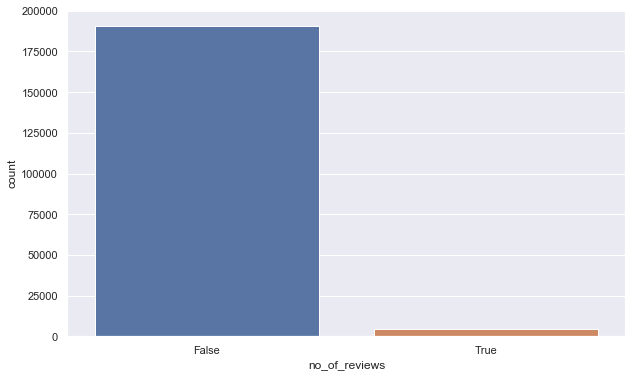

In [5]:
plt.figure(figsize = (10, 6))
sns.countplot(x = mult_reviews['no_of_reviews'] > 1)

From the above graph we could see that there are some reviews repeated more than once. We will drop the duplicates to analyze the data better and avoid reptitions.

In [6]:
data.drop_duplicates(inplace = True)
data.shape

(195752, 4)

In [7]:
np.random.seed(42)
review = pd.DataFrame(data['review'].sample(1000)).reset_index() # sampling 1000 reviews for the initial analysis
review.drop("index", axis = 1, inplace = True) # dropping the index column
review.head(10)

,review
0,"I love this seat, it's so easy to use and most..."
1,I love this mascara.\n\nIt's super easy to app...
2,I have tried too many different diapers/ brand...
3,I love a good lip gloss and this is absolutely...
4,"Cute blanket, great materials. The green cente..."
5,This monitor is fantastic. The picture is very...
6,So pleased with this. My mother purchased a d...
7,These are so soft and cute. They are very gent...
8,I bought this for my little girl when she was ...
9,Will this replace a pro fret job? Nah...That s...


From the few reviews above, we could see reviews related to products such as seat, mascara, monitor etc. This would help us to identify the number of clusters that we want to make.

Let us perform TF-IDF on the reviews and we will have some better idea on how many clusters we would like to have.

## Implement TF-IDF Transform

In [8]:
def quote_to_words(raw_quote):
    #removing raw letters,numbers,punctuations
    letters = re.sub("[^a-zA-Z]"," ",raw_quote)
    #creating an array , resolving whitespaces
    words = letters.lower().split()
    #create an array of stopwords so that we don't have to access corpus to search for a stopword
    stop = set(stopwords.words("english"))
    #removing stopwords from the raw_review
    meaningful_words = [w for w in words if w not in stop]
    #return a string with only the words that are important
    return(" ".join(meaningful_words))

In [33]:
clean_reviews = []

for i in range(review.review.size):
    clean_reviews.append(quote_to_words(review.review[i]))

In [34]:
review_series = pd.Series(clean_reviews)

#Creating work data
work_data = pd.DataFrame(review_series)

#Combining the fresh and quotes columns
work_data.rename(columns = {0 : 'review'}, inplace = True)

In [35]:
from sklearn.feature_extraction.text import CountVectorizer

vectorizer = CountVectorizer()
X = vectorizer.fit_transform(work_data['review']).toarray()
X.shape

(1000, 6598)

In [40]:
BOW = pd.DataFrame(X, columns = vectorizer.get_feature_names())
BOW.head()

,aa,aback,abandoned,ability,able,abound,abrading,abrupt,absent,absolute,...,zip,zipper,zippered,zipperpage,zippers,zips,zit,zone,zoo,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


#### Most commonly occurring words in the reviews

In [37]:
BOW.apply(np.sum, axis = 0).sort_values(ascending = False).head(10)

one       509
baby      464
use       461
like      408
great     367
would     344
get       291
little    287
well      278
really    268
dtype: int64

#### Calculating tf-idf for every word in the reviews to find the important words

In [41]:
BOW['total_words'] = BOW.sum(axis = 1)
BOW_tf_idf = BOW.apply(lambda x: ((x/BOW['total_words']) * np.log((1+len(BOW))/(x+1))))
BOW_tf_idf.drop('total_words', axis = 1, inplace = True)
BOW_tf_idf.head()

,aa,aback,abandoned,ability,able,abound,abrading,abrupt,absent,absolute,...,zip,zipper,zippered,zipperpage,zippers,zips,zit,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
BOW_tf_idf.sum().sort_values(ascending = False).head(10)

great     78.663635
baby      67.158095
use       64.431023
one       61.864850
like      54.786179
love      53.741700
well      47.852174
would     41.774582
easy      40.954785
little    39.249048
dtype: float64

#### Using sklearn tfidf vectorizer

In [74]:
from sklearn.feature_extraction.text import TfidfVectorizer
vec = TfidfVectorizer(stop_words='english')
XX = vec.fit_transform(work_data.review).toarray()
bow_vec = pd.DataFrame(XX, columns = vec.get_feature_names())
bow_vec.head()

,aa,aback,abandoned,ability,able,abound,abrading,abrupt,absent,absolute,...,zip,zipper,zippered,zipperpage,zippers,zips,zit,zone,zoo,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [44]:
bow_vec.sum().sort_values(ascending = False).head(10)

baby       29.644980
great      28.002028
use        27.413734
like       24.175163
love       22.782741
easy       20.405128
little     19.714460
really     18.164324
good       18.003841
product    17.825549
dtype: float64

## Implement k-Means clustering

In [172]:
print("The norm of the tfidf matrix is:", round(np.linalg.norm(X), 2))

The norm of the tfidf matrix is: 272.22


In [173]:
class Kmeans:
    """ 
        k: number of clusters
        
        max_iter: number of iterations to run algorithm, default: 200

        centroids: array, k, number_features
       
        cluster_labels: label for each data point
       
    """
    
    def __init__(self, k, seed = None, max_iter = 200):
        self.k = k
        self.seed = seed
        if self.seed is not None:
            np.random.seed(self.seed)
        self.max_iter = max_iter
        
            
    
    def initialise_centroids(self, data):
        """Randomly Initialise Centroids
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        centroids: array of k centroids chosen as random data points 
        """
        
        initial_centroids = np.random.permutation(data.shape[0])[:self.k]
        self.centroids = data[initial_centroids]
        print("The norm of the centroids is:", round(np.linalg.norm(self.centroids), 2))

        return self.centroids
    
    
    def assign_clusters(self, data):
        """Compute distance of data from clusters and assign data point
           to closest cluster.
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
            
        """
        
        if data.ndim == 1:
            data = data.reshape(-1, 1)
        
        dist_to_centroid =  pairwise_distances(data, self.centroids, metric = 'cosine')
        self.cluster_labels = np.argmin(dist_to_centroid, axis = 1)
        
        return  self.cluster_labels
    
    
    def update_centroids(self, data):
        """Computes average of all data points in cluster and
           assigns new centroids as average of data points
        
        Parameters
        -----------
        data: array or matrix, number_rows, number_features
        
        Returns
        -----------
        centroids: array, k, number_features
        """
        
        self.centroids = np.array([data[self.cluster_labels == i].mean(axis = 0) for i in range(self.k)])
        
        return self.centroids
    
    
    
    def predict(self, data):
        """Predict which cluster data point belongs to
        
        Parameters
        ----------
        data: array or matrix, number_rows, number_features
        
        Returns
        --------
        cluster_labels: index which minmises the distance of data to each
        cluster
        """
        
        return self.assign_clusters(data)
    
    def fit_kmeans(self, data):
        """
        This function contains the main loop to fit the algorithm
        Implements initialise centroids and update_centroids
        according to max_iter
        -----------------------
        
        Returns
        -------
        instance of kmeans class
            
        """
        self.centroids = self.initialise_centroids(data)
        
        # Main kmeans loop
        for iter in range(self.max_iter):

            self.cluster_labels = self.assign_clusters(data)
            self.centroids = self.update_centroids(data)          
            if iter % 100 == 0:
                print("Running Model Iteration %d " %iter)
        print("Model finished running")
        return self   

In [174]:
kmeans_model = Kmeans(3, seed = 42, max_iter = 50)

In [175]:
fitted = kmeans_model.fit_kmeans(X)

The norm of the centroids is: 22.91
Running Model Iteration 0 
Model finished running


In [176]:
predicted = kmeans_model.predict(X)

In [177]:
predicted.shape

(1000,)

## Analyzing the clusters

In [178]:
review['cluster_labels'] = predicted

In [179]:
g = review.groupby('cluster_labels')

In [180]:
pd.set_option('display.max_colwidth', -1)
g.get_group(0).head(10)

,review,cluster_labels
1,"I love this mascara.\n\nIt's super easy to apply and doesn't clump. My lashes look both thicker and darker. I've also had no eye irritation.\n\nThe want is comfortable as well.\n\nNo smudging, no raccoon eyes, and I find that I don't need to reapply it during the day. Once in the morning and that's it.\n\nVery pleased with this!",0
2,I have tried too many different diapers/ brands/ systems to list and these are one of my favorites! I bought one originally just to try it and I've bought 4 more since. They also make wonderful newborn diapers call Tini Fit Tots Bots.,0
3,I love a good lip gloss and this is absolutely perfect. The applicator has a small indentation which makes application easy. This has a very light fruity scent. This gloss glides on blissfully it is not sticky or too shiny. I have medium skin tone and this color is perfect and I personally think will compliment any skin tone. This is one of the best lip glosses I have used.,0
4,"Cute blanket, great materials. The green center is a terry cloth material which is great for soaking up the drool that goes with teething. Not shown in the picture is a green ring attachment that goes through the purple corner. The ring itself isn't great, the opening is too large to keep it attatched, but it was easily swapped out with another ring link. I liked having the option to attach it to the carseat or stroller so it wasn't dropped though.",0
7,These are so soft and cute. They are very gentle on babies skin. It's not scratchy or course like some of the other products out there. Highly recommended. Get's softer with each washing.,0
9,Will this replace a pro fret job? Nah...That said this works great for use a few times a year to clean the frets an make them shiny and smooth.End results[...],0
11,I ordered this for my new grandsons room at my home. I put it together and was kind of dissapointed at how it tipped over easily. So I actually put a waste basket in it to help it stand up and will use it for waste. I mean it works great to cover the trash can so it worked out. Just not sure if I would recomend.,0
14,"Great bottle set, but my son is so rarely bottle fed that we actually ended up returning them. Think about how often you're going to be nursing, pumping, and bottle feeding before investing in lots of bottles and storage.",0
16,WE LOVE THE PRINT. THE BLANKET IS SUPER SOFT AND SUPER CUTE. WOULD RECOMMEND THIS BLANKET TO ANYONE FOR A LITTLE GIRL.,0
20,"Goes on very smoothly and doesn't cake or look dry. I like the marbled appearance, it allows it to blend much smoother. I first used this alone, just to see how well it covers and it did a great job, just looked a little too light, even on my fair skin. Then I tried it again but this time over the light foundation I wear and found that it worked well to cover uneven spots but with it the cakey-masklike look that a lot of people want to avoid.",0


From looking at the samples of the first cluster, we could see that it contains baby and beauty products with an inclination towards 

In [181]:
g.get_group(1).head(10)

,review,cluster_labels
5,"This monitor is fantastic. The picture is very clear, even in the dark, and the sound is super sensitive. The battery lasts a long time, and after almost 2 years of daily use it is still working perfect and we have had zero problems with it. Every once in a while we'll get a tad bit of static, but the house is pretty big, so it's expected. This was definitely worth the money.",1
6,"So pleased with this. My mother purchased a different kind for her house, and the quality just didn't compare.1 The single piece of molded foam makes for super easy cleaning.2 The pee guard is great to keep messes from happening.3 The design is genius. My son clearly feels more supported and comfortable on this than other types.",1
8,"I bought this for my little girl when she was 12 months old. I never used exersausers much with my three older children because they were very mobile very young and crawled/walked around to different pile of toys I had laying around for them. However, Anna wasn't so mobile, so I got this for her.SHE LOVED IT! I didn't even ever put any batteries in it. She would play with it for hours and loved all the toys. It really does grow with the child.One bad thing I noticed was that ours came with a food tray that never stayed on right. Plus, who wants food near the exersaucer? Soft food (baby food, etc.) would get smeared all over it; hard food (cheerios, etc.) would get crushed into it and shoved into little crevasses...never did understand the food tray coming with a toy?? I don't think it was any reason to dock it a star, though.This is a great toy!",1
10,"Bought this and wish I had not. Have had it for three months, and my husband uses it a few times a week and when he does it easily shows any sweat once it dries. The quality is poor and the stitching is fraying / coming apart. Not impressed.",1
12,"- they are waaay too high to be useful as snack traps.- once they get gross with soggy goldfish there is no way to clean them because they stay permanently attached. So unlike other strollers where you can easily pop out the snack tray and hose it off in the sink, this one stays gross & you have to do your best with wet wipes.- it makes the folded configuration a little thicker- if the kids are buckled, the tray is so high they can't reach it. (this goes with my first point)- it is soooo difficult to install & one screw on mine constantly falls off so I finally just left it off.- too expensive- it's impossible for the kids to climb in. a 2 year old & 4 year old both have the same problem. they can't go under it because humans don't twist that way (even them who can climb on anything) so my 2 year old son tries to climb over it if I don't get to him quick enough & it gives me a heart attack each time I catch him trying that b/che'll fall & hit his head one of these days if I don't grab him quick enough. So I have to lift my heavy 4 year old & 2 year old in EVERY TIME. lift them in, lift them out, lift them in, lift them out. and it's not just a short lift, you have to lift them high up and they have to contort themselves to fit under it.awful design. Bob folks - you gotta fix this. this design hasn't changed for years. Change the seats so they sit straight upright and add a snack tray that will funcion as a snack tray. I know you can do it :)",1
15,"I have owned this toy twice so far. I bought one when my daughter was 6 months old and thought she would love it. She ended up not liking it at all. She was not a ""bouncy"" baby. We ended up taking it back for an exersaucer instead. Fast forward 2 years later I had my son, he just turned 6 months and he's a bouncer. The exersaucer is not his thing, I ended up buying this again. He LOVES this so much. Onto the review of the jumperoo nowLike every other baby toy it takes up room, I do like that it folds down a bit but still bulky so be prepared if you have a small apartment. It has adjustable straps to grow with baby. My son is on the number 2 setting at 6 m

In [182]:
g.get_group(2).head(10)

,review,cluster_labels
0,"I love this seat, it's so easy to use and most importantly clean. You can also remove the tray,and keep the baby buckled in while you tidy up. Fabulous",2
13,"My child is scared of &#34;big potties&#34;. When we are on the road or out shopping, this is the lifesaver for &#34;I have to pee now daddy!&#34;. We love it.",2
18,"It does the job, but in one travel, it had 2 holes probably from the way the airlines handle the things. But it does keep the car seat safe and clean. The quality is pretty good.",2
38,"The chicco car seats are great - easy to use, high safety ratings, and nice looking. My only complaint about this car seat is that my son sweats like crazy in it. We live at 7,000ft so not in a warm climate by any means - houses where we live don't even have AC. I could not imagine how much he'd sweat in a warm or humid climate. Even after short rides in a well ventilated cool car his head totally soaks the head rest and the back of his shirt is totally soaked through. Going to look at other options for our next baby as our son loves his car seat and going for rides until he is soaking in sweat.",2
85,"It doesn't really keep the car seat cool, but it does keep it cooler than the rest of the car, which is noticeable when you are in very hot temperatures. We traveled through areas with 3 digit temperatures (Texas, New Mexico, Nevada, Southern California, etc). The most important part is that the metal parts of the buckles don't get hot enough to burn the baby, and this is what it did. For the price, great product.",2
96,"You can't put a price on your child's safety, but $60 plus for the car seat base it a little ridiculous.",2
124,This works great to entertain my 3 month old who gets fussy if the car seat isn't moving! It helps to keep him happy while I'm trying to pack up the car and get him situated. It's great for those down times when the car isn't moving yet.The only thing I do wish it had was an option to have it stay on for a few minutes. He's too little to hit the button himself to play the noises and lights so I have to hit the button and I can't safely do that from the front seat while we are driving!,2
148,"We got this seat in Pink Mist at Target. It's awesome. The handle and overall shape is great, very easy to carry and move around. The seat is much lighter than many of the others we looked at but still sturdy. The seat is not bulky at all and leaves enough room for our older 2 to be able to buckle their seat belts in the backseat! The seat comes with an insert over the back to pad around babies head as well as a guard over the feet. Both of these are removable as baby grows. With our other kids we had to go out and get special inserts to go around the baby's head to keep them snug in their seats. No need here! This seat is designed for the safety of newborns. But again, you can remove the extra pieces for more space later when baby has more head control. The latches are a little pesky - you have to line up the two sides together before latching them into the center piece. But after a few tries you get the hang of it. It's very easy to adjust the straps with the slack and a release button located at the front of the seat. Love the base. Seat snaps in and out very easily and it's easy to belt into the car.Overall we're happy with the safety ratings, the design, especially the weight and ease of use, and we would recommend this seat!",2
154,"I have been using this stroller for about a year for walks around the neighborhood, trips to the zoo, and parks. It is great on paved surfaces and packed sand/dirt park trails. My kid seems pretty happy in it.Pros:light (14lbs)compact (fits easily into my compact car trunk)roomy basket (my giant diaper bag fits in there)peekaboo window in canopyeasy to recline when kid is sleepingcomfort padding on shoulder strapsCons:the double rear wheels are close-set so I step on them sometimesdifficult to close upno cup holder (for the pilot!)",2
181,"First, we lov

#### Take more samples and try for different clusters

In [192]:
np.random.seed(42)
review_1 = pd.DataFrame(data['review'].sample(10000)).reset_index() # sampling 1000 reviews for the initial analysis
review_1.drop("index", axis = 1, inplace = True) # dropping the index column

In [193]:
clean_reviews = []

for i in range(review_1.review.size):
    clean_reviews.append(quote_to_words(review_1.review[i]))
    
review_series = pd.Series(clean_reviews)

#Creating work data
work_data = pd.DataFrame(review_series)

#Combining the fresh and quotes columns
work_data.rename(columns = {0 : 'review'}, inplace = True)

XXX = vectorizer.fit_transform(work_data['review']).toarray()
XXX.shape

(10000, 19040)

In [194]:
BOW = pd.DataFrame(XXX, columns = vectorizer.get_feature_names())
BOW['total_words'] = BOW.sum(axis = 1)
BOW_tf_idf = BOW.apply(lambda x: ((x/BOW['total_words']) * np.log((1+len(BOW))/(x+1))))
BOW_tf_idf.drop('total_words', axis = 1, inplace = True)
BOW_tf_idf.head()

MemoryError: 